[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/13aw4XftC8c2uZ1w6NpIo2n4P_9MdYSo4#scrollTo=MHAcSyqvykmC)


In [44]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import seaborn as sns
from warnings import filterwarnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

In [47]:
filterwarnings(action='ignore')

In [48]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [49]:
train_df

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,1300000.0,...,0,0,1100000.0,0,0,0,0.0,0.0,14800000,0.0,1200000.0,0.0,0.0,0,0,0,0,0.0,4000000,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4454,ff85154c8,1065000.0,0.0,0,0.0,0,0,0,0,0,70000.0,0.0,0.0,0,0,6000000,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6000000,0,0.0,0,0,0.0,0,0,0.0,0,0,920000.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4455,ffb6b3f4f,48000.0,0.0,0,0.0,0,0,0,0,0,375000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,80000.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,375000.0,0,0,0.0,0.0,0.0,80000.0,0,0,0,0,0,0,0
4456,ffcf61eb6,2800000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,30000.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,4291000.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4457,ffea67e98,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,200000.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


## EDA

### Normalizing the target

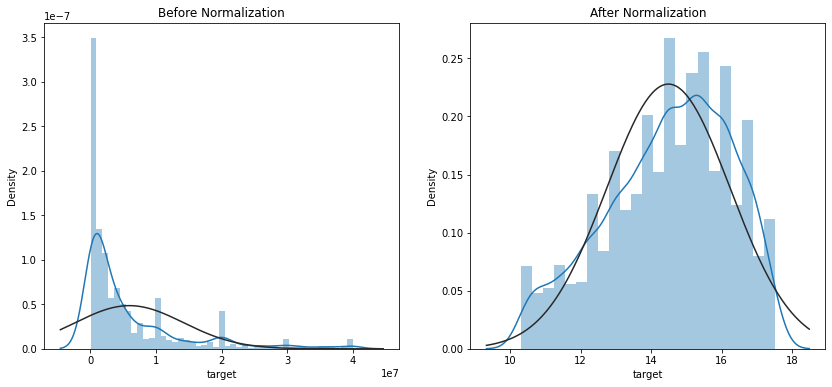

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.distplot(train_df['target'], fit=stats.norm, ax=ax[0])
ax[0].set_title('Before Normalization')

# use log1p instead of log to get the normalized value for even tiny values -> 0
train_df['target'] = np.log1p(train_df['target'])
ax[1].set_title('After Normalization')
sns.distplot(train_df['target'], fit=stats.norm, ax=ax[1])
plt.show()

In [51]:
# check for duplicated rows
print('num of duplicated rows in train set: ', train_df.duplicated().sum())
# drop ID because there is no need to keep it
train_df.drop(['ID'], axis=1, inplace=True)

# check for duplicated rows
print('num of duplicated rows in test set: ', test_df.duplicated().sum())
# drop ID because there is no need to keep it
ids = test_df['ID']
test_df.drop(['ID'], axis=1, inplace=True)

num of duplicated rows in train set:  0
num of duplicated rows in test set:  0


In [52]:
# check for null values
print('num of null values in train set', train_df.isnull().sum().sum())

# check for null values
print('num of null values in test set', test_df.isnull().sum().sum())

num of null values in train set 0
num of null values in test set 0


In [53]:
# check if there're any feature with 0 variance(they give us no information)

zero_var_train = []
for col in train_df.columns:
    if train_df[col].var() == 0:
        zero_var_train.append(col)

print('num of columns with zero variance in the train set: ', len(zero_var_train))

zero_var_test = []
for col in test_df.columns:
    if test_df[col].var() == 0:
        zero_var_test.append(col)

print('num of columns with zero variance in the test set: ', len(zero_var_test))

num of columns with zero variance in the train set:  256
num of columns with zero variance in the test set:  0


In [54]:
# check for duplicate columns

def duplicate_columns(df):
    dups = []
    columns = df.columns

    for i in range(len(columns)):
        col1 = df.iloc[:, i]
        for j in range(i + 1, len(columns)):
            col2 = df.iloc[:, j]
            # break early if dtypes aren't the same (helps deal with
            # categorical dtypes)
            if col1.dtype is not col2.dtype:
                break
            # otherwise compare values
            if col1.equals(col2):
                dups.append(columns[i])
                break
    return dups


train_dups = duplicate_columns(train_df)
print('num of duplicated cols in the train set: ', len(train_dups))

# test_dups = duplicate_columns(test_df)
# print('num of duplicated cols in the test set: ', len(test_dups))

num of duplicated cols in the train set:  27


In [55]:
# dropping useless features

useless_features = list(set(zero_var_train + train_dups))

train_df = train_df.drop(useless_features, axis=1)
test_df = test_df.drop(useless_features, axis=1)

## Adding some statistical features

In [56]:
# adding some statistical features to boost the model

for df in [train_df, test_df]:
    df['max'] = df.max(axis=1)
    df['min'] = df.min(axis=1)
    df['mean'] = df.mean(axis=1)
    df['non_zero_sum'] = (df != 0).sum(axis=1)
    df['zero_sum'] = (df == 0).sum(axis=1)
    df['sum'] = df.sum(axis=1)
    df['variance'] = df.var(axis=1)
    df['median'] = df.median(axis=1)
    df['mode'] = df.mode(axis=1)
    df['log_sum'] = np.log1p(df['sum'])
    df['log_non_zero'] = np.log1p(df['non_zero_sum'])
    df['log_zero'] = np.log1p(df['zero_sum'])
    df['log_mean'] = np.log1p(df['mean'])
    df['log_max'] = np.log1p(df['max'])
    df['log_min'] = np.log1p(df['min'])
    df['log_variance'] = np.log1p(df['variance'])
    df['log_mode'] = np.log1p(df['mode'])
    df['log_median'] = np.log1p(df['median'])

## Correlation

### Pearson

In [79]:
pearson_selection = train_df.corr().nlargest(20, 'target')['target'].index

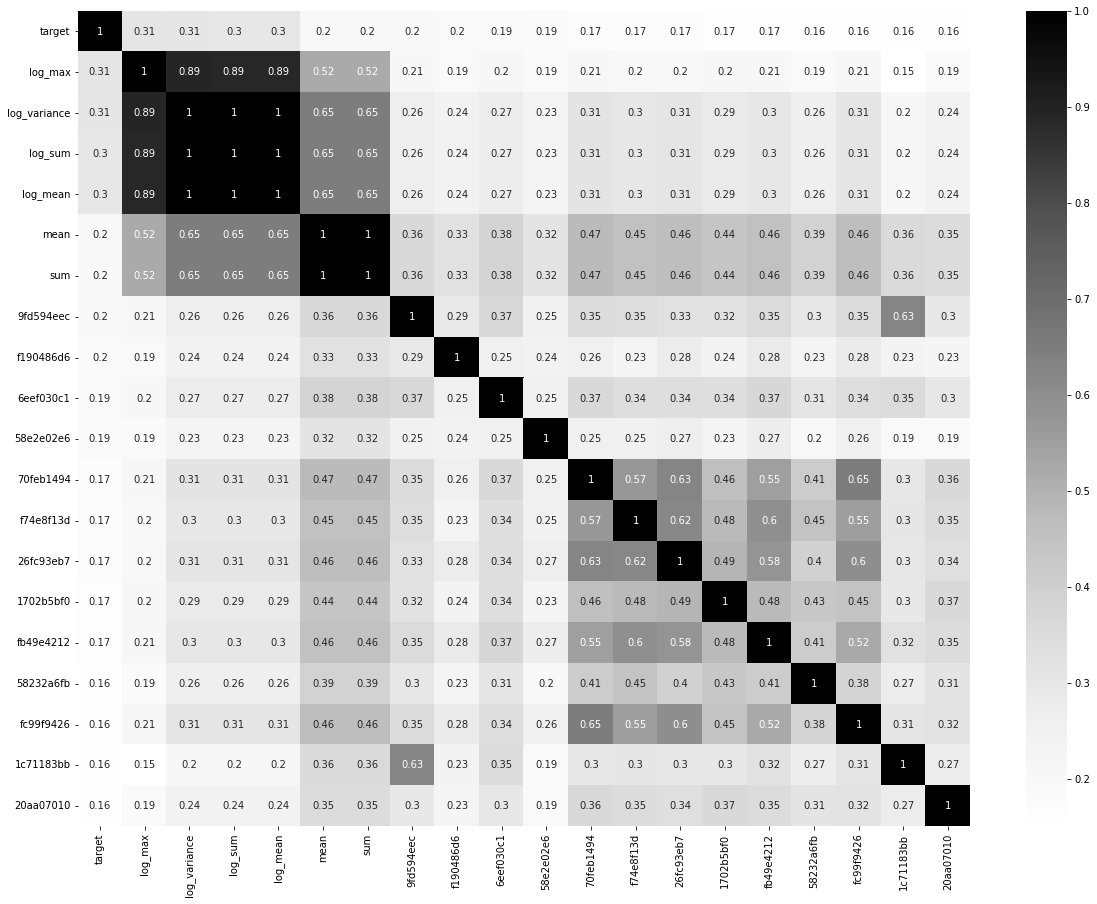

In [80]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df[pearson_selection].corr(), cmap='Greys', annot=True)

### Spearman

In [81]:
spearman_selection = train_df.corr(
    method='spearman').nlargest(20, 'target')['target'].index

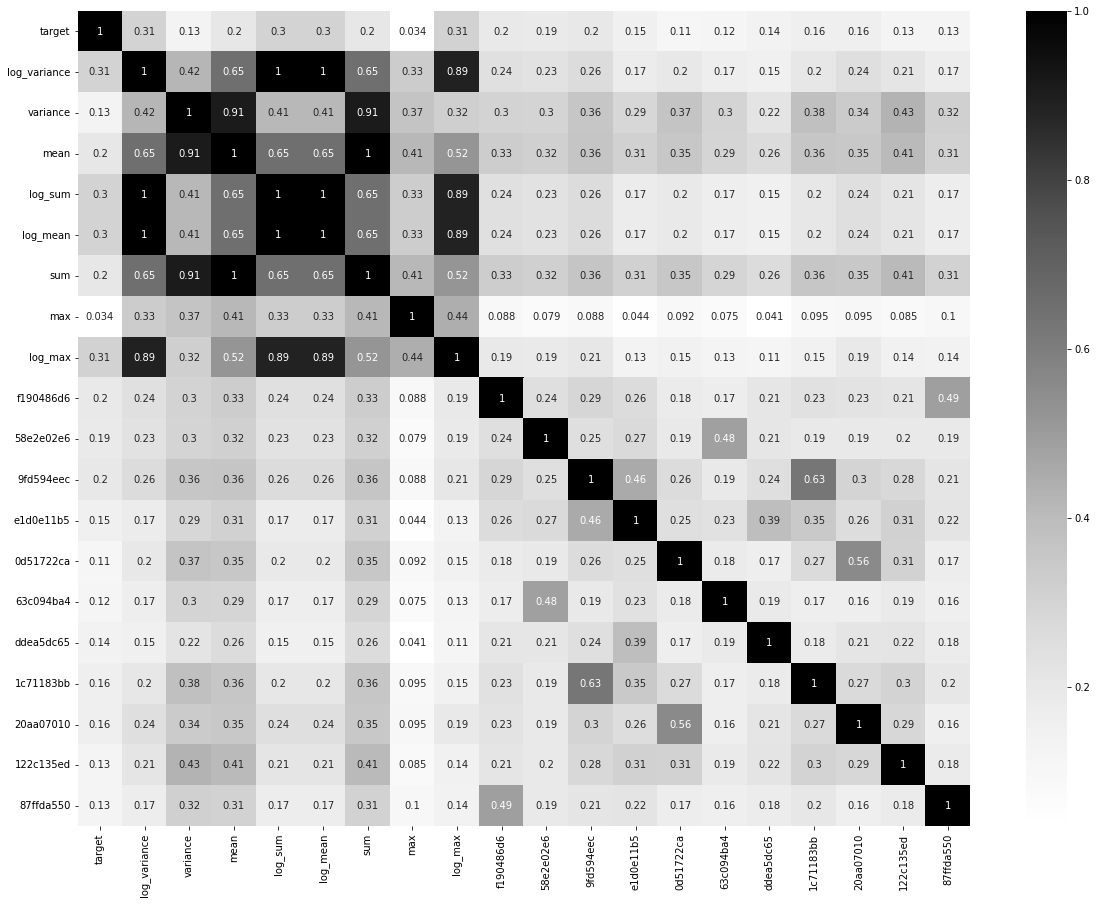

In [82]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df[spearman_selection].corr(), cmap='Greys', annot=True)

## Train and Validation split

In [111]:
X = train_df.drop(['target'], axis=1)
y = train_df['target']

In [112]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Feature importance using SHAP

### XGBoost

In [113]:
from xgboost import XGBRegressor
import shap

xgb = XGBRegressor(verbose=False).fit(X_train, y_train)

[19:23:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


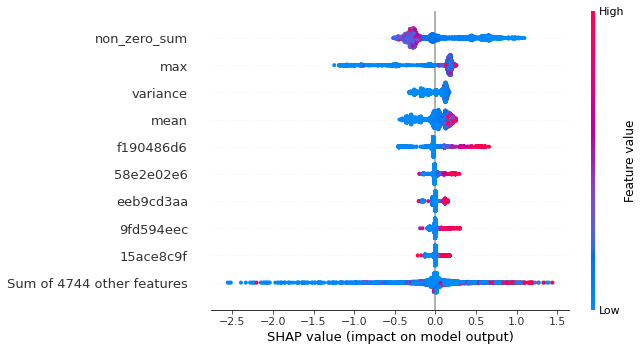

In [114]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

In [115]:
X_importance = X_val

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_importance)

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame(
    [X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

In [116]:
shap_selected_features_xgb = list(
    importance_df[importance_df['shap_importance'] != 0]['column_name'])

In [117]:
len(shap_selected_features_xgb)

306

### CatBoost

In [118]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(random_state=42, verbose=False).fit(X_train, y_train)
explainer = shap.Explainer(cat)
shap_values = explainer(X_train)

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_importance)

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame(
    [X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

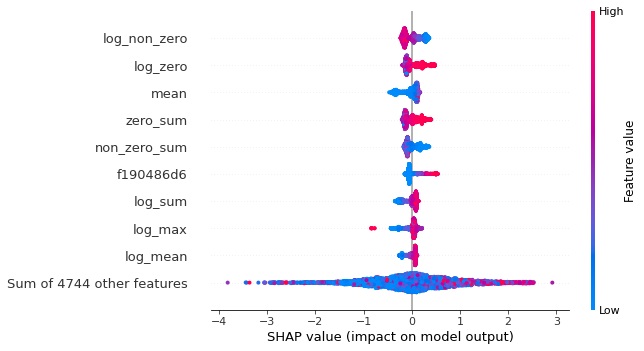

In [119]:
explainer = shap.Explainer(cat)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

In [120]:
shap_selected_features_cat = list(
    importance_df[importance_df['shap_importance'] != 0]['column_name'])

In [121]:
len(shap_selected_features_cat)

1388

### LightGBM

In [122]:
from lightgbm import LGBMRegressor

X_importance = X_val
lgbm = LGBMRegressor(random_state=42).fit(X_train, y_train)
explainer = shap.Explainer(lgbm)
shap_values = explainer(X_train)

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_importance)

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame(
    [X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

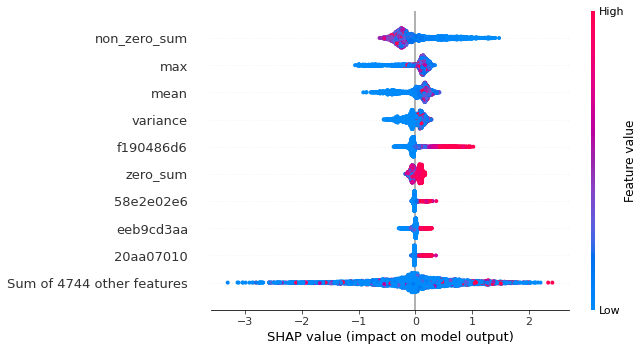

In [123]:
explainer = shap.Explainer(lgbm)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

In [124]:
shap_selected_features_lgbm = list(
    importance_df[importance_df['shap_importance'] != 0]['column_name'])

In [125]:
len(shap_selected_features_lgbm)

951

In [126]:
shap_selection = common_elements = np.intersect1d(
    shap_selected_features_xgb, shap_selected_features_cat)
shap_selection = np.intersect1d(shap_selection, shap_selected_features_lgbm)

In [127]:
len(shap_selection)

166

## Training model

In [88]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error

In [100]:
X_train = X_train[shap_selection]
X_val = X_val[shap_selection]
test_df = test_df[shap_selection]

In [101]:
# xgboost
xgb = XGBRegressor(colsample_bytree=0.055, colsample_bylevel=0.5,
                   gamma=1.5, learning_rate=0.02, max_depth=32,
                   objective='reg:linear', booster='gbtree',
                   min_child_weight=57, n_estimators=1000, reg_alpha=0,
                             reg_lambda=0, eval_metric='rmse', subsample=0.7,
                   silent=1, n_jobs=-1, early_stopping_rounds=14,
                   random_state=42, nthread=-1)

# randomforest
rf = RandomForestRegressor(random_state=42)

# catboost
cb = CatBoostRegressor(random_state=42, verbose=False)

# lightgbm
lgbm = LGBMRegressor(objective='regression', num_leaves=144,
                     learning_rate=0.005, n_estimators=720, max_depth=13,
                     metric='rmse', is_training_metric=True,
                     max_bin=55, bagging_fraction=0.8, verbose=-1,
                     bagging_freq=5, feature_fraction=0.9, random_state=42)


# defining ensemble
ensemble_regressor = VotingRegressor(
    [('rf', rf), ('xgb', xgb), ('cb', cb), ('lgbm', lgbm)])

# training each model
for reg in (rf, xgb, cb, lgbm, ensemble_regressor):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    print(reg.__class__.__name__, mean_squared_error(y_val, y_pred))

RandomForestRegressor 1.9405439632460144
XGBRegressor 1.9060170351338899
CatBoostRegressor 1.980235600047484
LGBMRegressor 1.9128519145135217
VotingRegressor 1.8618994874353851


## Predicting test set 

In [102]:
prediction = np.expm1(ensemble_regressor.predict(test_df))

In [103]:
sub = pd.DataFrame({'ID': ids, 'target': prediction})

In [104]:
sub.to_csv('sub.csv', index=False)